<a href="https://colab.research.google.com/github/morteza80mr/DeepLearning2024/blob/main/Mini%20Project%201/Customer_Segmentation_and_Classification_Using_PyTorch_and_ADOPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import Dependencies

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1B9P9qL6Nqipfi4w0YCDe1mCh4-ZoAUpl -O teleCust1000t.csv

!git clone https://github.com/iShohei220/adopt.git
!pip install -r adopt/requirements.txt
!pip install torch seaborn matplotlib scikit-learn

import sys
sys.path.append('/content/adopt')  # Adjust path if needed

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from adopt import ADOPT

Downloading...
From: https://drive.google.com/uc?id=1B9P9qL6Nqipfi4w0YCDe1mCh4-ZoAUpl
To: /content/teleCust1000t.csv
100% 37.0k/37.0k [00:00<00:00, 52.5MB/s]
fatal: destination path 'adopt' already exists and is not an empty directory.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'adopt/requirements.txt'


Set random seeds for reproducibility

In [ ]:
np.random.seed(8)
torch.manual_seed(8)

# Step 1: Load and Inspect Data

In [ ]:
data = pd.read_csv('teleCust1000t.csv')
print("Data Info:")
print(data.info())
print("\nData Description:")
print(data.describe())
print("\nData Head:")
print(data.head())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   region   1000 non-null   int64  
 1   tenure   1000 non-null   int64  
 2   age      1000 non-null   int64  
 3   marital  1000 non-null   int64  
 4   address  1000 non-null   int64  
 5   income   1000 non-null   float64
 6   ed       1000 non-null   int64  
 7   employ   1000 non-null   int64  
 8   retire   1000 non-null   float64
 9   gender   1000 non-null   int64  
 10  reside   1000 non-null   int64  
 11  custcat  1000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 93.9 KB
None

Data Description:
          region       tenure          age      marital      address  \
count  1000.0000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      2.0220    35.526000    41.684000     0.495000    11.551000   
std       0.8162    21.359812    12.558816     0.500225    

# Step 2: Correlation Analysis and Plotting

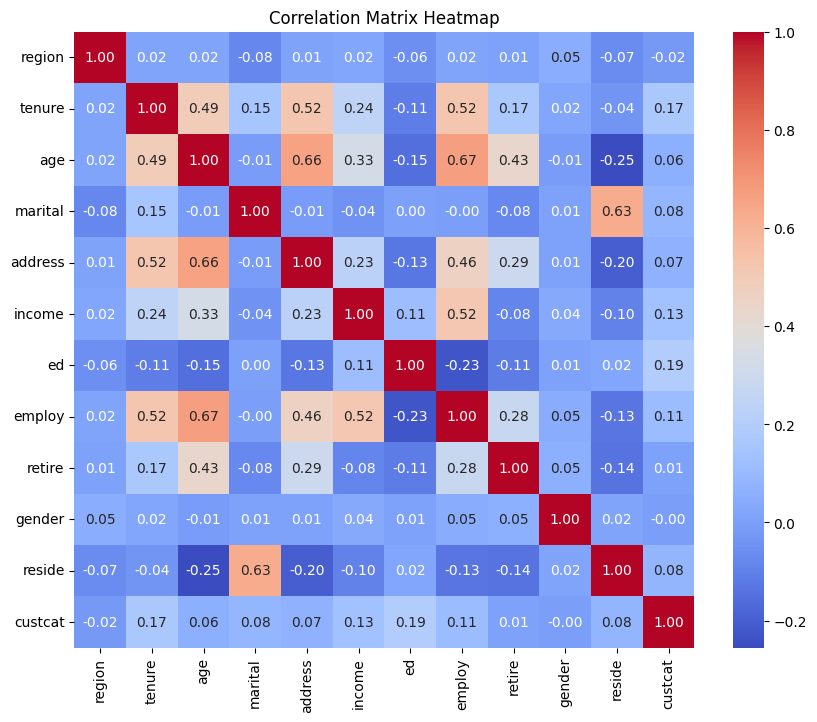

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

Identify top correlated features with 'custcat'

In [ ]:
target_correlation = correlation_matrix['custcat'].sort_values(ascending=False)
print("Correlation of features with 'custcat':\n", target_correlation)

Correlation of features with 'custcat':
 custcat    1.000000
ed         0.193864
tenure     0.166691
income     0.134525
employ     0.110011
marital    0.083836
reside     0.082022
address    0.067913
age        0.056909
retire     0.008908
gender    -0.004966
region    -0.023771
Name: custcat, dtype: float64


Select top two features (excluding 'custcat')

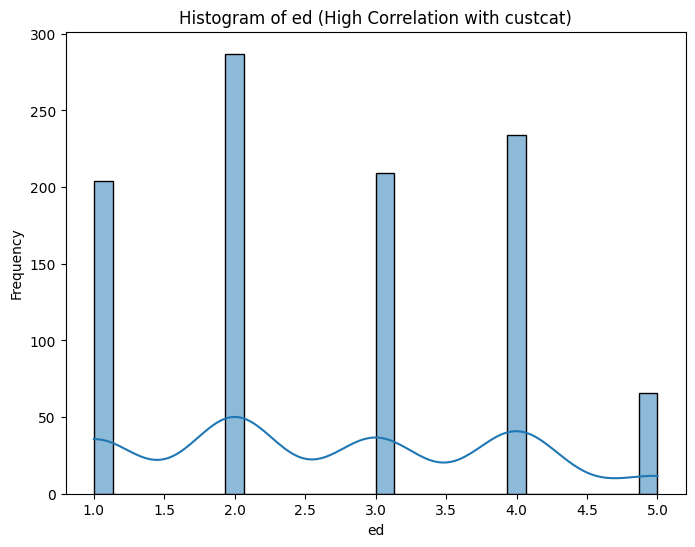

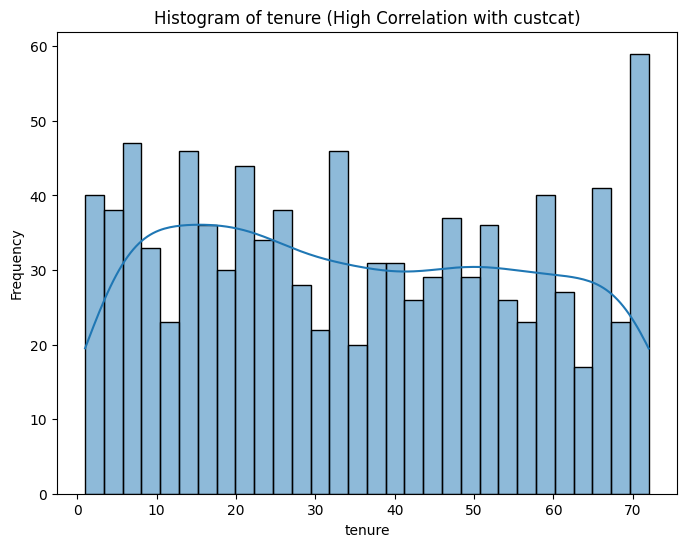

In [ ]:
top_features = target_correlation[1:3].index
for feature in top_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Histogram of {feature} (High Correlation with custcat)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Step 3: Data Preprocessing

Normalize and Split into Train/Validation/Test

In [ ]:
X = data.drop(columns=['custcat']).values
y = (data['custcat'] - 1).values  # from [1,4] to [0,3]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3,
                                                    random_state=8, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
                                                random_state=8, stratify=y_temp)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)
input_dim = X_train.shape[1]

Shapes:
X_train: (700, 11) y_train: (700,)
X_val: (150, 11) y_val: (150,)
X_test: (150, 11) y_test: (150,)


Convert to PyTorch tensors

In [ ]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

Create DataLoaders

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Definition Function

We will create a flexible MLP with configurable layers, BatchNorm, Dropout, L2, etc.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=1, neurons=32, batch_norm=False,
                 dropout_rate=0.0, num_classes=4):
        super(MLP, self).__init__()
        layers = []
        in_dim = input_dim
        for i in range(hidden_layers):
            layers.append(nn.Linear(in_dim, neurons))
            layers.append(nn.ReLU())
            if batch_norm:
                layers.append(nn.BatchNorm1d(neurons))
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            in_dim = neurons
        layers.append(nn.Linear(in_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

Training and Evaluation Functions

In [ ]:
def train_model(model, optimizer, train_loader, val_loader, epochs=100, patience=10, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    best_state_dict = None

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, total = 0.0, 0, 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*Xb.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == yb).sum().item()
            total += Xb.size(0)

        train_acc = train_correct / total
        val_loss, val_acc = evaluate_model(model, val_loader, device=device)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/total:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    # restore best weights
    model.load_state_dict(best_state_dict)
    return model

def evaluate_model(model, data_loader, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    model.to(device)
    loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for Xb, yb in data_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            outputs = model(Xb)
            l = criterion(outputs, yb)
            loss += l.item()*Xb.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == yb).sum().item()
            total += Xb.size(0)
    return loss/total, correct/total

def test_accuracy(model, test_loader, device='cpu'):
    _, acc = evaluate_model(model, test_loader, device=device)
    return acc

Helper to directly train and evaluate a model configuration

In [ ]:
def train_and_test(hidden_layers=1, neurons=32, batch_norm=False, dropout_rate=0.0,
                   l2_reg=0.0, optimizer_type='SGD', lr=0.01, epochs=100, patience=10,
                   device='cpu'):
    model = MLP(input_dim, hidden_layers, neurons, batch_norm, dropout_rate)
    if optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=l2_reg)
    elif optimizer_type == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=l2_reg)
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)
    elif optimizer_type == 'ADOPT':
        optimizer = ADOPT(model.parameters(), lr=lr, weight_decay=l2_reg)
    else:
        raise ValueError("Unknown optimizer type")

    model = train_model(model, optimizer, train_loader, val_loader, epochs, patience, device=device)
    acc = test_accuracy(model, test_loader, device=device)
    return model, acc

# Step 4: Experiments

4.1 - Impact of Number of Neurons with 1 Hidden Layer

In [ ]:
configurations_neurons = [16, 32, 64]
results_neurons = []
for n in configurations_neurons:
    print(f"Training model with {n} Neurons")
    _, acc = train_and_test(hidden_layers=1, neurons=n, optimizer_type='SGD', lr=0.01)
    results_neurons.append((n, acc))
    print(f"Test Accuracy with {n} neurons: {acc:.4f}\n")

# Find best neuron config
best_neurons = max(results_neurons, key=lambda x: x[1])[0]
print("Best number of neurons:", best_neurons)

Training model with 16 Neurons
Epoch 1/100, Train Loss: 1.3985, Train Acc: 0.2257, Val Loss: 1.4015, Val Acc: 0.1800
Epoch 2/100, Train Loss: 1.3955, Train Acc: 0.2257, Val Loss: 1.3988, Val Acc: 0.2000
Epoch 3/100, Train Loss: 1.3931, Train Acc: 0.2400, Val Loss: 1.3966, Val Acc: 0.2333
Epoch 4/100, Train Loss: 1.3911, Train Acc: 0.2386, Val Loss: 1.3948, Val Acc: 0.2200
Epoch 5/100, Train Loss: 1.3894, Train Acc: 0.2557, Val Loss: 1.3932, Val Acc: 0.2333
Epoch 6/100, Train Loss: 1.3879, Train Acc: 0.2643, Val Loss: 1.3918, Val Acc: 0.2467
Epoch 7/100, Train Loss: 1.3867, Train Acc: 0.2743, Val Loss: 1.3907, Val Acc: 0.2533
Epoch 8/100, Train Loss: 1.3856, Train Acc: 0.2800, Val Loss: 1.3896, Val Acc: 0.2533
Epoch 9/100, Train Loss: 1.3846, Train Acc: 0.2829, Val Loss: 1.3886, Val Acc: 0.2467
Epoch 10/100, Train Loss: 1.3837, Train Acc: 0.2886, Val Loss: 1.3877, Val Acc: 0.2467
Epoch 11/100, Train Loss: 1.3829, Train Acc: 0.2900, Val Loss: 1.3869, Val Acc: 0.2600
Epoch 12/100, Train L

4.2 - Add Batch Normalization

In [ ]:
print("Training with Batch Normalization:")
_, acc_bn = train_and_test(hidden_layers=1, neurons=best_neurons, batch_norm=True, optimizer_type='SGD')
print(f"Accuracy with BatchNorm: {acc_bn:.4f}")

# Compare to no BN
_, acc_no_bn = train_and_test(hidden_layers=1, neurons=best_neurons, batch_norm=False, optimizer_type='SGD')
print(f"Accuracy without BatchNorm: {acc_no_bn:.4f}")

Training with Batch Normalization:
Epoch 1/100, Train Loss: 1.5032, Train Acc: 0.2429, Val Loss: 1.4006, Val Acc: 0.2867
Epoch 2/100, Train Loss: 1.4450, Train Acc: 0.2543, Val Loss: 1.3960, Val Acc: 0.2800
Epoch 3/100, Train Loss: 1.4065, Train Acc: 0.2857, Val Loss: 1.3770, Val Acc: 0.3400
Epoch 4/100, Train Loss: 1.3934, Train Acc: 0.3157, Val Loss: 1.3869, Val Acc: 0.3533
Epoch 5/100, Train Loss: 1.3690, Train Acc: 0.3214, Val Loss: 1.3603, Val Acc: 0.3533
Epoch 6/100, Train Loss: 1.3520, Train Acc: 0.3457, Val Loss: 1.3756, Val Acc: 0.3267
Epoch 7/100, Train Loss: 1.3376, Train Acc: 0.3543, Val Loss: 1.3482, Val Acc: 0.3533
Epoch 8/100, Train Loss: 1.3270, Train Acc: 0.3443, Val Loss: 1.3404, Val Acc: 0.3800
Epoch 9/100, Train Loss: 1.3201, Train Acc: 0.3657, Val Loss: 1.3307, Val Acc: 0.3733
Epoch 10/100, Train Loss: 1.3169, Train Acc: 0.3714, Val Loss: 1.3204, Val Acc: 0.3933
Epoch 11/100, Train Loss: 1.3010, Train Acc: 0.3814, Val Loss: 1.3223, Val Acc: 0.4000
Epoch 12/100, Tra

4.3 - Add Dropout

In [ ]:
dropout_rate = 0.5
_, acc_dropout = train_and_test(hidden_layers=1, neurons=best_neurons, dropout_rate=dropout_rate, optimizer_type='SGD')
print(f"Accuracy with Dropout: {acc_dropout:.4f}")

Epoch 1/100, Train Loss: 1.4173, Train Acc: 0.2200, Val Loss: 1.4087, Val Acc: 0.2267
Epoch 2/100, Train Loss: 1.4102, Train Acc: 0.2114, Val Loss: 1.4054, Val Acc: 0.2267
Epoch 3/100, Train Loss: 1.4080, Train Acc: 0.1929, Val Loss: 1.4023, Val Acc: 0.2333
Epoch 4/100, Train Loss: 1.4071, Train Acc: 0.2314, Val Loss: 1.3998, Val Acc: 0.2133
Epoch 5/100, Train Loss: 1.4043, Train Acc: 0.2057, Val Loss: 1.3977, Val Acc: 0.2000
Epoch 6/100, Train Loss: 1.3969, Train Acc: 0.2286, Val Loss: 1.3956, Val Acc: 0.2200
Epoch 7/100, Train Loss: 1.3949, Train Acc: 0.2043, Val Loss: 1.3937, Val Acc: 0.2067
Epoch 8/100, Train Loss: 1.3949, Train Acc: 0.2343, Val Loss: 1.3923, Val Acc: 0.2133
Epoch 9/100, Train Loss: 1.3953, Train Acc: 0.2500, Val Loss: 1.3910, Val Acc: 0.2000
Epoch 10/100, Train Loss: 1.3925, Train Acc: 0.2300, Val Loss: 1.3899, Val Acc: 0.1867
Epoch 11/100, Train Loss: 1.3924, Train Acc: 0.2371, Val Loss: 1.3888, Val Acc: 0.2133
Epoch 12/100, Train Loss: 1.3890, Train Acc: 0.2386,

4.4 - Add L2 Regularization

In [ ]:
l2_rate = 0.0001
_, acc_l2 = train_and_test(hidden_layers=1, neurons=best_neurons, l2_reg=l2_rate, optimizer_type='SGD')
print(f"Accuracy with L2 Regularization: {acc_l2:.4f}")

# Combine BN + Dropout + L2
_, acc_combined = train_and_test(hidden_layers=1, neurons=best_neurons,
                                 batch_norm=True, dropout_rate=0.5, l2_reg=0.0001,
                                 optimizer_type='SGD', lr=0.01)
print(f"Accuracy with BN+Dropout+L2: {acc_combined:.4f}")

Epoch 1/100, Train Loss: 1.3848, Train Acc: 0.2814, Val Loss: 1.3889, Val Acc: 0.2800
Epoch 2/100, Train Loss: 1.3836, Train Acc: 0.2814, Val Loss: 1.3877, Val Acc: 0.2800
Epoch 3/100, Train Loss: 1.3825, Train Acc: 0.2814, Val Loss: 1.3867, Val Acc: 0.2800
Epoch 4/100, Train Loss: 1.3817, Train Acc: 0.2814, Val Loss: 1.3858, Val Acc: 0.2800
Epoch 5/100, Train Loss: 1.3809, Train Acc: 0.2814, Val Loss: 1.3850, Val Acc: 0.2800
Epoch 6/100, Train Loss: 1.3803, Train Acc: 0.2814, Val Loss: 1.3842, Val Acc: 0.2800
Epoch 7/100, Train Loss: 1.3794, Train Acc: 0.2814, Val Loss: 1.3836, Val Acc: 0.2800
Epoch 8/100, Train Loss: 1.3788, Train Acc: 0.2871, Val Loss: 1.3830, Val Acc: 0.2800
Epoch 9/100, Train Loss: 1.3783, Train Acc: 0.2886, Val Loss: 1.3825, Val Acc: 0.2800
Epoch 10/100, Train Loss: 1.3778, Train Acc: 0.2886, Val Loss: 1.3819, Val Acc: 0.2800
Epoch 11/100, Train Loss: 1.3773, Train Acc: 0.2886, Val Loss: 1.3815, Val Acc: 0.2867
Epoch 12/100, Train Loss: 1.3767, Train Acc: 0.2871,

Combine BN + Dropout + L2

In [ ]:
_, acc_combined = train_and_test(hidden_layers=1, neurons=best_neurons,
                                 batch_norm=True, dropout_rate=0.5, l2_reg=0.0001,
                                 optimizer_type='SGD', lr=0.01)
print(f"Accuracy with BN+Dropout+L2: {acc_combined:.4f}")

Epoch 1/100, Train Loss: 1.5745, Train Acc: 0.2086, Val Loss: 1.4135, Val Acc: 0.2533
Epoch 2/100, Train Loss: 1.5251, Train Acc: 0.2314, Val Loss: 1.4027, Val Acc: 0.3067
Epoch 3/100, Train Loss: 1.4600, Train Acc: 0.2629, Val Loss: 1.3847, Val Acc: 0.3200
Epoch 4/100, Train Loss: 1.4309, Train Acc: 0.2843, Val Loss: 1.3616, Val Acc: 0.3333
Epoch 5/100, Train Loss: 1.3709, Train Acc: 0.3143, Val Loss: 1.3491, Val Acc: 0.3467
Epoch 6/100, Train Loss: 1.3592, Train Acc: 0.2943, Val Loss: 1.3363, Val Acc: 0.3867
Epoch 7/100, Train Loss: 1.3693, Train Acc: 0.3514, Val Loss: 1.3277, Val Acc: 0.4000
Epoch 8/100, Train Loss: 1.3390, Train Acc: 0.3443, Val Loss: 1.3209, Val Acc: 0.4133
Epoch 9/100, Train Loss: 1.3594, Train Acc: 0.3429, Val Loss: 1.3158, Val Acc: 0.4000
Epoch 10/100, Train Loss: 1.3390, Train Acc: 0.3414, Val Loss: 1.3106, Val Acc: 0.3933
Epoch 11/100, Train Loss: 1.3233, Train Acc: 0.3600, Val Loss: 1.3073, Val Acc: 0.3867
Epoch 12/100, Train Loss: 1.3070, Train Acc: 0.3829,

4.5 - Different Optimizers (RMSprop, Adam)

In [ ]:
# RMSprop
_, acc_rms = train_and_test(hidden_layers=1, neurons=best_neurons, batch_norm=True, dropout_rate=0.5, l2_reg=0.0001,
                            optimizer_type='RMSprop', lr=0.001)
print(f"Accuracy with RMSprop: {acc_rms:.4f}")

# Adam
_, acc_adam = train_and_test(hidden_layers=1, neurons=best_neurons, batch_norm=True, dropout_rate=0.5, l2_reg=0.0001,
                             optimizer_type='Adam', lr=0.001)
print(f"Accuracy with Adam: {acc_adam:.4f}")

Epoch 1/100, Train Loss: 1.5379, Train Acc: 0.2871, Val Loss: 1.3585, Val Acc: 0.3733
Epoch 2/100, Train Loss: 1.4027, Train Acc: 0.3114, Val Loss: 1.3378, Val Acc: 0.3667
Epoch 3/100, Train Loss: 1.4041, Train Acc: 0.3200, Val Loss: 1.3361, Val Acc: 0.3733
Epoch 4/100, Train Loss: 1.3566, Train Acc: 0.3414, Val Loss: 1.3359, Val Acc: 0.3733
Epoch 5/100, Train Loss: 1.3576, Train Acc: 0.3629, Val Loss: 1.3390, Val Acc: 0.3867
Epoch 6/100, Train Loss: 1.3278, Train Acc: 0.3671, Val Loss: 1.3448, Val Acc: 0.3800
Epoch 7/100, Train Loss: 1.3270, Train Acc: 0.3671, Val Loss: 1.3430, Val Acc: 0.3867
Epoch 8/100, Train Loss: 1.3366, Train Acc: 0.3529, Val Loss: 1.3392, Val Acc: 0.3733
Epoch 9/100, Train Loss: 1.3370, Train Acc: 0.3643, Val Loss: 1.3360, Val Acc: 0.3733
Epoch 10/100, Train Loss: 1.2890, Train Acc: 0.3871, Val Loss: 1.3248, Val Acc: 0.3733
Epoch 11/100, Train Loss: 1.3075, Train Acc: 0.3800, Val Loss: 1.3189, Val Acc: 0.3800
Epoch 12/100, Train Loss: 1.2983, Train Acc: 0.3943,

ADOPT Optimizer

In [ ]:
_, acc_adopt = train_and_test(hidden_layers=1, neurons=best_neurons, batch_norm=True, dropout_rate=0.5,
                              l2_reg=0.0001, optimizer_type='ADOPT', lr=0.001)
print(f"Accuracy with ADOPT: {acc_adopt:.4f}")

Epoch 1/100, Train Loss: 1.5608, Train Acc: 0.2757, Val Loss: 1.3942, Val Acc: 0.2400
Epoch 2/100, Train Loss: 1.4955, Train Acc: 0.2486, Val Loss: 1.3963, Val Acc: 0.2667
Epoch 3/100, Train Loss: 1.4530, Train Acc: 0.2971, Val Loss: 1.3883, Val Acc: 0.3000
Epoch 4/100, Train Loss: 1.4372, Train Acc: 0.2757, Val Loss: 1.3765, Val Acc: 0.3067
Epoch 5/100, Train Loss: 1.4037, Train Acc: 0.3243, Val Loss: 1.3677, Val Acc: 0.3267
Epoch 6/100, Train Loss: 1.3971, Train Acc: 0.2900, Val Loss: 1.3561, Val Acc: 0.3333
Epoch 7/100, Train Loss: 1.3750, Train Acc: 0.3443, Val Loss: 1.3469, Val Acc: 0.3733
Epoch 8/100, Train Loss: 1.3620, Train Acc: 0.3357, Val Loss: 1.3465, Val Acc: 0.3533
Epoch 9/100, Train Loss: 1.3478, Train Acc: 0.3600, Val Loss: 1.3483, Val Acc: 0.3467
Epoch 10/100, Train Loss: 1.3380, Train Acc: 0.3814, Val Loss: 1.3429, Val Acc: 0.3467
Epoch 11/100, Train Loss: 1.3330, Train Acc: 0.3500, Val Loss: 1.3424, Val Acc: 0.3600
Epoch 12/100, Train Loss: 1.3350, Train Acc: 0.3557,

4.1 - Impact of Number of Neurons with 2 Hidden Layer

In [ ]:
configurations_neurons_2_layer = [16, 32, 64]
results_neurons_2_layer = []
for n in configurations_neurons_2_layer:
    print(f"Training 2-Layer model with {n} Neurons")
    _, acc = train_and_test(hidden_layers=2, neurons=n, optimizer_type='SGD', lr=0.01, batch_norm=True)
    results_neurons_2_layer.append((n, acc))
    print(f"Test Accuracy with 2 layers and {n} neurons: {acc:.4f}\n")

# Find best neuron config for 2 layers
best_neurons_2_layer = max(results_neurons_2_layer, key=lambda x: x[1])[0]
print("Best neuron configuration for 2 hidden layers:", best_neurons_2_layer)

Training 2-Layer model with 16 Neurons
Epoch 1/100, Train Loss: 1.4619, Train Acc: 0.2743, Val Loss: 1.3929, Val Acc: 0.1933
Epoch 2/100, Train Loss: 1.3789, Train Acc: 0.2957, Val Loss: 1.3672, Val Acc: 0.2867
Epoch 3/100, Train Loss: 1.3382, Train Acc: 0.3643, Val Loss: 1.3351, Val Acc: 0.3667
Epoch 4/100, Train Loss: 1.3195, Train Acc: 0.3671, Val Loss: 1.3172, Val Acc: 0.3600
Epoch 5/100, Train Loss: 1.3080, Train Acc: 0.3971, Val Loss: 1.3056, Val Acc: 0.4000
Epoch 6/100, Train Loss: 1.2933, Train Acc: 0.3829, Val Loss: 1.2968, Val Acc: 0.4067
Epoch 7/100, Train Loss: 1.2843, Train Acc: 0.3786, Val Loss: 1.2945, Val Acc: 0.4067
Epoch 8/100, Train Loss: 1.2771, Train Acc: 0.3843, Val Loss: 1.2897, Val Acc: 0.4200
Epoch 9/100, Train Loss: 1.2728, Train Acc: 0.4014, Val Loss: 1.2837, Val Acc: 0.4267
Epoch 10/100, Train Loss: 1.2458, Train Acc: 0.4229, Val Loss: 1.2795, Val Acc: 0.4333
Epoch 11/100, Train Loss: 1.2477, Train Acc: 0.4243, Val Loss: 1.2805, Val Acc: 0.4533
Epoch 12/100,

4.2 - Add Batch Normalization

In [ ]:
print("Training 2-Layer model with Batch Normalization:")
_, acc_bn_2_layer = train_and_test(hidden_layers=2, neurons=best_neurons_2_layer, batch_norm=True, optimizer_type='SGD')
print(f"Accuracy with BatchNorm (2 layers): {acc_bn_2_layer:.4f}")

# Compare to no BN
_, acc_no_bn_2_layer = train_and_test(hidden_layers=2, neurons=best_neurons_2_layer, batch_norm=False, optimizer_type='SGD')
print(f"Accuracy without BatchNorm (2 layers): {acc_no_bn_2_layer:.4f}")

Training 2-Layer model with Batch Normalization:
Epoch 1/100, Train Loss: 1.4463, Train Acc: 0.2714, Val Loss: 1.3750, Val Acc: 0.3400
Epoch 2/100, Train Loss: 1.3484, Train Acc: 0.3486, Val Loss: 1.3397, Val Acc: 0.3800
Epoch 3/100, Train Loss: 1.3103, Train Acc: 0.3771, Val Loss: 1.3168, Val Acc: 0.3400
Epoch 4/100, Train Loss: 1.2663, Train Acc: 0.4229, Val Loss: 1.3134, Val Acc: 0.3400
Epoch 5/100, Train Loss: 1.2495, Train Acc: 0.4243, Val Loss: 1.3178, Val Acc: 0.3600
Epoch 6/100, Train Loss: 1.2369, Train Acc: 0.3929, Val Loss: 1.3156, Val Acc: 0.3667
Epoch 7/100, Train Loss: 1.2224, Train Acc: 0.4243, Val Loss: 1.3050, Val Acc: 0.3867
Epoch 8/100, Train Loss: 1.2083, Train Acc: 0.4114, Val Loss: 1.3121, Val Acc: 0.3800
Epoch 9/100, Train Loss: 1.2029, Train Acc: 0.4400, Val Loss: 1.3066, Val Acc: 0.3400
Epoch 10/100, Train Loss: 1.1870, Train Acc: 0.4257, Val Loss: 1.3004, Val Acc: 0.3400
Epoch 11/100, Train Loss: 1.1914, Train Acc: 0.4486, Val Loss: 1.3087, Val Acc: 0.3533
Epo

4.3 - Add Dropout

In [ ]:
dropout_rate = 0.5
_, acc_dropout_2_layer = train_and_test(hidden_layers=2, neurons=best_neurons_2_layer, dropout_rate=dropout_rate, optimizer_type='SGD')
print(f"Accuracy with Dropout (2 layers, rate={dropout_rate}): {acc_dropout_2_layer:.4f}")

Epoch 1/100, Train Loss: 1.3884, Train Acc: 0.2686, Val Loss: 1.3850, Val Acc: 0.2667
Epoch 2/100, Train Loss: 1.3861, Train Acc: 0.2771, Val Loss: 1.3840, Val Acc: 0.2667
Epoch 3/100, Train Loss: 1.3901, Train Acc: 0.2557, Val Loss: 1.3832, Val Acc: 0.2667
Epoch 4/100, Train Loss: 1.3799, Train Acc: 0.2871, Val Loss: 1.3825, Val Acc: 0.2600
Epoch 5/100, Train Loss: 1.3841, Train Acc: 0.2900, Val Loss: 1.3819, Val Acc: 0.2800
Epoch 6/100, Train Loss: 1.3882, Train Acc: 0.2700, Val Loss: 1.3813, Val Acc: 0.2800
Epoch 7/100, Train Loss: 1.3899, Train Acc: 0.2614, Val Loss: 1.3808, Val Acc: 0.2533
Epoch 8/100, Train Loss: 1.3787, Train Acc: 0.3029, Val Loss: 1.3803, Val Acc: 0.2333
Epoch 9/100, Train Loss: 1.3869, Train Acc: 0.2814, Val Loss: 1.3798, Val Acc: 0.2667
Epoch 10/100, Train Loss: 1.3787, Train Acc: 0.3057, Val Loss: 1.3794, Val Acc: 0.2667
Epoch 11/100, Train Loss: 1.3882, Train Acc: 0.2586, Val Loss: 1.3791, Val Acc: 0.2800
Epoch 12/100, Train Loss: 1.3839, Train Acc: 0.2714,

4.4 - Add L2 Regularization

In [ ]:
l2_rate = 0.0001
_, acc_l2_2_layer = train_and_test(hidden_layers=2, neurons=best_neurons_2_layer, l2_reg=l2_rate, optimizer_type='SGD')
print(f"Accuracy with L2 Regularization (2 layers, l2={l2_rate}): {acc_l2_2_layer:.4f}")

Epoch 1/100, Train Loss: 1.3933, Train Acc: 0.2314, Val Loss: 1.3893, Val Acc: 0.2333
Epoch 2/100, Train Loss: 1.3909, Train Acc: 0.2329, Val Loss: 1.3874, Val Acc: 0.2333
Epoch 3/100, Train Loss: 1.3888, Train Acc: 0.2357, Val Loss: 1.3858, Val Acc: 0.2333
Epoch 4/100, Train Loss: 1.3870, Train Acc: 0.2371, Val Loss: 1.3845, Val Acc: 0.2467
Epoch 5/100, Train Loss: 1.3856, Train Acc: 0.2371, Val Loss: 1.3833, Val Acc: 0.2733
Epoch 6/100, Train Loss: 1.3843, Train Acc: 0.2786, Val Loss: 1.3823, Val Acc: 0.3333
Epoch 7/100, Train Loss: 1.3832, Train Acc: 0.2929, Val Loss: 1.3815, Val Acc: 0.3267
Epoch 8/100, Train Loss: 1.3823, Train Acc: 0.3143, Val Loss: 1.3807, Val Acc: 0.3200
Epoch 9/100, Train Loss: 1.3814, Train Acc: 0.3100, Val Loss: 1.3801, Val Acc: 0.3200
Epoch 10/100, Train Loss: 1.3807, Train Acc: 0.3100, Val Loss: 1.3795, Val Acc: 0.3267
Epoch 11/100, Train Loss: 1.3800, Train Acc: 0.3071, Val Loss: 1.3790, Val Acc: 0.3267
Epoch 12/100, Train Loss: 1.3794, Train Acc: 0.3100,

Combine BN + Dropout + L2

In [ ]:
_, acc_combined_2_layer = train_and_test(
    hidden_layers=2, neurons=best_neurons_2_layer,
    batch_norm=True, dropout_rate=dropout_rate, l2_reg=l2_rate,
    optimizer_type='SGD', lr=0.01
)
print(f"Accuracy with BN+Dropout+L2 (2 layers): {acc_combined_2_layer:.4f}")

Epoch 1/100, Train Loss: 1.5487, Train Acc: 0.2700, Val Loss: 1.3928, Val Acc: 0.2467
Epoch 2/100, Train Loss: 1.4721, Train Acc: 0.3029, Val Loss: 1.3622, Val Acc: 0.3000
Epoch 3/100, Train Loss: 1.4619, Train Acc: 0.3043, Val Loss: 1.3361, Val Acc: 0.3133
Epoch 4/100, Train Loss: 1.4111, Train Acc: 0.3186, Val Loss: 1.3190, Val Acc: 0.3467
Epoch 5/100, Train Loss: 1.3858, Train Acc: 0.3257, Val Loss: 1.3124, Val Acc: 0.3200
Epoch 6/100, Train Loss: 1.3507, Train Acc: 0.3400, Val Loss: 1.3037, Val Acc: 0.3667
Epoch 7/100, Train Loss: 1.3624, Train Acc: 0.3500, Val Loss: 1.3001, Val Acc: 0.3733
Epoch 8/100, Train Loss: 1.3381, Train Acc: 0.3586, Val Loss: 1.2918, Val Acc: 0.3400
Epoch 9/100, Train Loss: 1.3284, Train Acc: 0.3529, Val Loss: 1.2798, Val Acc: 0.3867
Epoch 10/100, Train Loss: 1.3306, Train Acc: 0.3557, Val Loss: 1.2807, Val Acc: 0.3933
Epoch 11/100, Train Loss: 1.3559, Train Acc: 0.3386, Val Loss: 1.2787, Val Acc: 0.3733
Epoch 12/100, Train Loss: 1.3145, Train Acc: 0.3500,

4.5 - Different Optimizers (RMSprop, Adam) for 2 Hidden Layers

In [ ]:
# RMSprop
_, acc_rms_2_layer = train_and_test(
    hidden_layers=2, neurons=best_neurons_2_layer, batch_norm=True, dropout_rate=dropout_rate, l2_reg=l2_rate,
    optimizer_type='RMSprop', lr=0.001
)
print(f"Accuracy with RMSprop (2 layers): {acc_rms_2_layer:.4f}")

# Adam
_, acc_adam_2_layer = train_and_test(
    hidden_layers=2, neurons=best_neurons_2_layer, batch_norm=True, dropout_rate=dropout_rate, l2_reg=l2_rate,
    optimizer_type='Adam', lr=0.001
)
print(f"Accuracy with Adam (2 layers): {acc_adam_2_layer:.4f}")

Epoch 1/100, Train Loss: 1.4888, Train Acc: 0.2929, Val Loss: 1.3592, Val Acc: 0.3000
Epoch 2/100, Train Loss: 1.3898, Train Acc: 0.3343, Val Loss: 1.3088, Val Acc: 0.3467
Epoch 3/100, Train Loss: 1.3785, Train Acc: 0.3357, Val Loss: 1.2942, Val Acc: 0.3600
Epoch 4/100, Train Loss: 1.3349, Train Acc: 0.3714, Val Loss: 1.2904, Val Acc: 0.3600
Epoch 5/100, Train Loss: 1.3368, Train Acc: 0.3500, Val Loss: 1.2935, Val Acc: 0.3533
Epoch 6/100, Train Loss: 1.3026, Train Acc: 0.3757, Val Loss: 1.2867, Val Acc: 0.3333
Epoch 7/100, Train Loss: 1.3099, Train Acc: 0.3914, Val Loss: 1.2838, Val Acc: 0.3333
Epoch 8/100, Train Loss: 1.2699, Train Acc: 0.4071, Val Loss: 1.2847, Val Acc: 0.3667
Epoch 9/100, Train Loss: 1.2799, Train Acc: 0.3800, Val Loss: 1.2777, Val Acc: 0.3800
Epoch 10/100, Train Loss: 1.2748, Train Acc: 0.3814, Val Loss: 1.2787, Val Acc: 0.3533
Epoch 11/100, Train Loss: 1.2826, Train Acc: 0.3971, Val Loss: 1.2754, Val Acc: 0.3800
Epoch 12/100, Train Loss: 1.2962, Train Acc: 0.3814,

ADOPT Optimizer for 2 Hidden Layers

In [ ]:
_, acc_adopt_2_layer = train_and_test(
    hidden_layers=2, neurons=best_neurons_2_layer, batch_norm=True, dropout_rate=dropout_rate,
    l2_reg=l2_rate, optimizer_type='ADOPT', lr=0.001
)
print(f"Accuracy with ADOPT Optimizer (2 layers): {acc_adopt_2_layer:.4f}")

Epoch 1/100, Train Loss: 1.5712, Train Acc: 0.2571, Val Loss: 1.3898, Val Acc: 0.2667
Epoch 2/100, Train Loss: 1.4327, Train Acc: 0.3086, Val Loss: 1.3566, Val Acc: 0.3333
Epoch 3/100, Train Loss: 1.3958, Train Acc: 0.3329, Val Loss: 1.3321, Val Acc: 0.3867
Epoch 4/100, Train Loss: 1.3985, Train Acc: 0.3500, Val Loss: 1.3201, Val Acc: 0.3867
Epoch 5/100, Train Loss: 1.3785, Train Acc: 0.3557, Val Loss: 1.2972, Val Acc: 0.4000
Epoch 6/100, Train Loss: 1.3350, Train Acc: 0.3586, Val Loss: 1.3005, Val Acc: 0.3933
Epoch 7/100, Train Loss: 1.3107, Train Acc: 0.3543, Val Loss: 1.2904, Val Acc: 0.3800
Epoch 8/100, Train Loss: 1.3321, Train Acc: 0.3743, Val Loss: 1.2867, Val Acc: 0.3867
Epoch 9/100, Train Loss: 1.2803, Train Acc: 0.4171, Val Loss: 1.2943, Val Acc: 0.3733
Epoch 10/100, Train Loss: 1.2975, Train Acc: 0.3943, Val Loss: 1.2915, Val Acc: 0.4133
Epoch 11/100, Train Loss: 1.3146, Train Acc: 0.3786, Val Loss: 1.2871, Val Acc: 0.4200
Epoch 12/100, Train Loss: 1.2652, Train Acc: 0.4014,

# Step 5: Evaluate on Test Data and Compare Predictions for 10 Random Samples

Let's pick two of our best models, e.g. one with Adam and one with ADOPT

Epoch 1/100, Train Loss: 1.5425, Train Acc: 0.2571, Val Loss: 1.3931, Val Acc: 0.2400
Epoch 2/100, Train Loss: 1.4887, Train Acc: 0.2657, Val Loss: 1.3759, Val Acc: 0.3333
Epoch 3/100, Train Loss: 1.4473, Train Acc: 0.2757, Val Loss: 1.3574, Val Acc: 0.3200
Epoch 4/100, Train Loss: 1.4233, Train Acc: 0.2914, Val Loss: 1.3375, Val Acc: 0.3600
Epoch 5/100, Train Loss: 1.3940, Train Acc: 0.3029, Val Loss: 1.3265, Val Acc: 0.3333
Epoch 6/100, Train Loss: 1.3726, Train Acc: 0.3243, Val Loss: 1.3189, Val Acc: 0.3467
Epoch 7/100, Train Loss: 1.3291, Train Acc: 0.3543, Val Loss: 1.3101, Val Acc: 0.3533
Epoch 8/100, Train Loss: 1.3287, Train Acc: 0.3529, Val Loss: 1.3046, Val Acc: 0.3733
Epoch 9/100, Train Loss: 1.3262, Train Acc: 0.3500, Val Loss: 1.3014, Val Acc: 0.3667
Epoch 10/100, Train Loss: 1.3085, Train Acc: 0.3714, Val Loss: 1.2975, Val Acc: 0.3867
Epoch 11/100, Train Loss: 1.3147, Train Acc: 0.3814, Val Loss: 1.2953, Val Acc: 0.3800
Epoch 12/100, Train Loss: 1.3197, Train Acc: 0.3357,

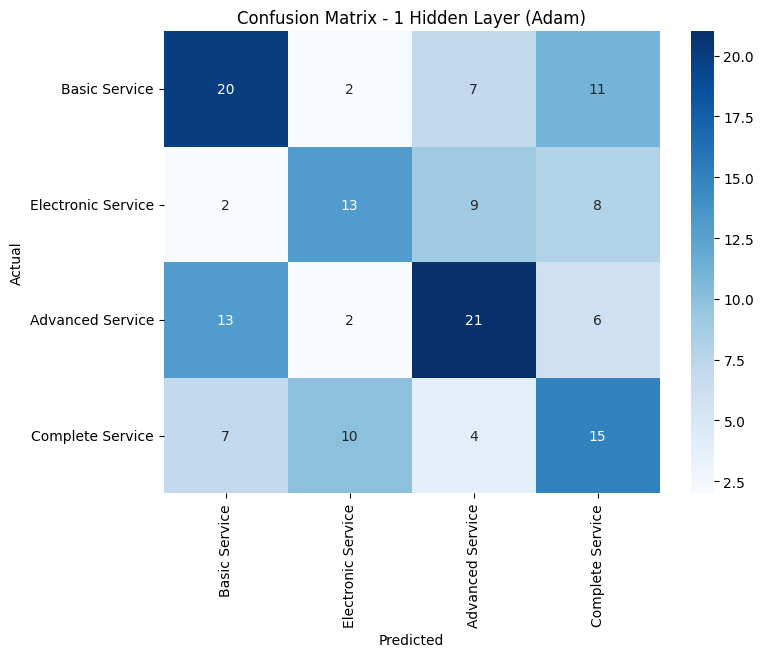

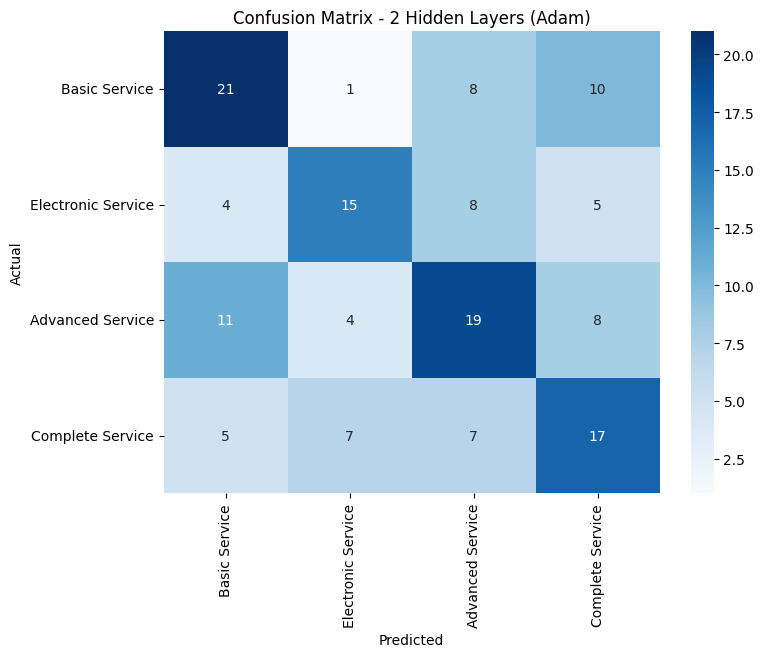

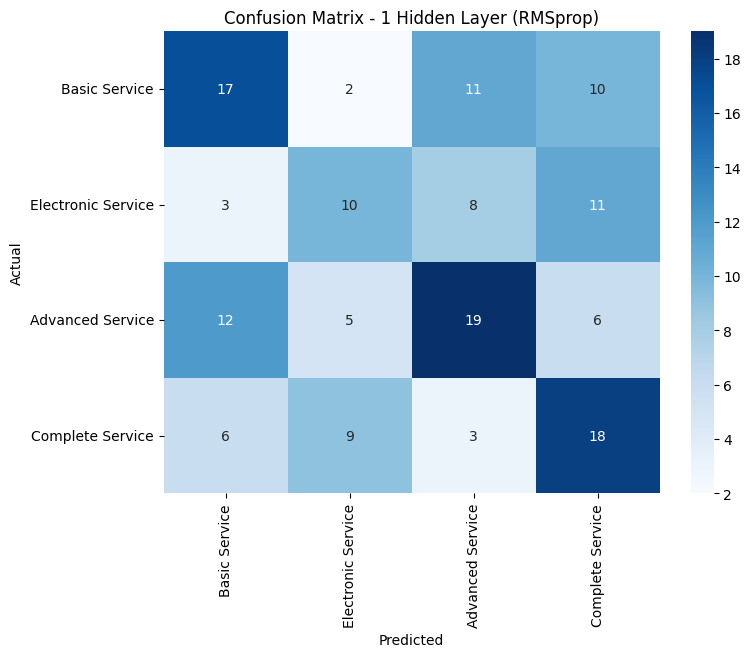

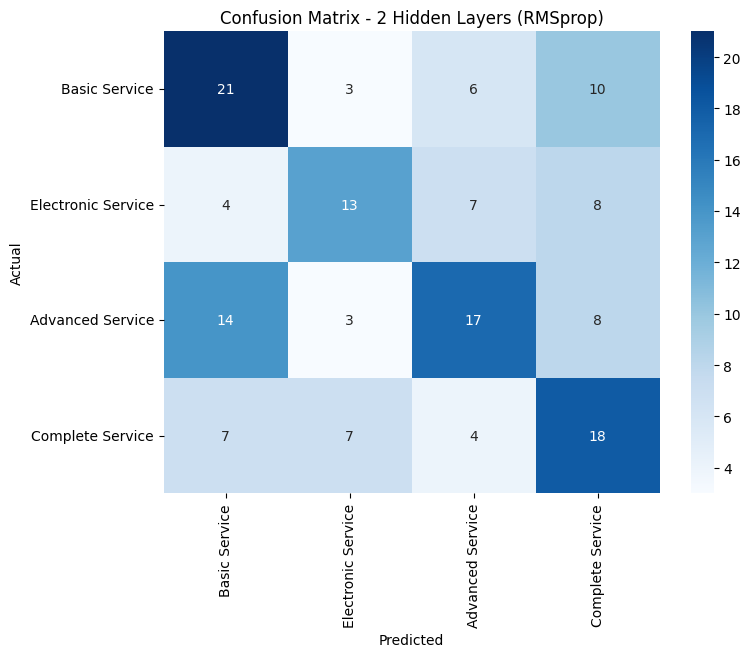

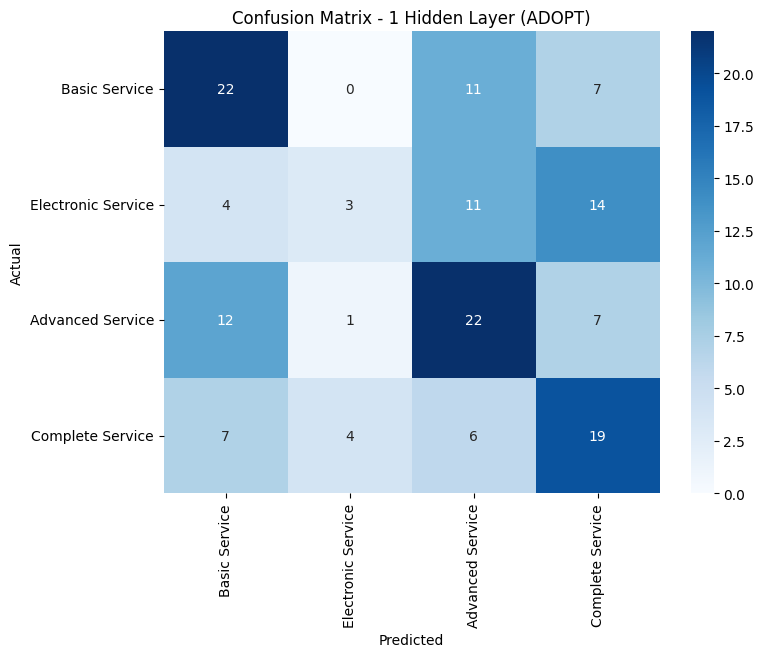

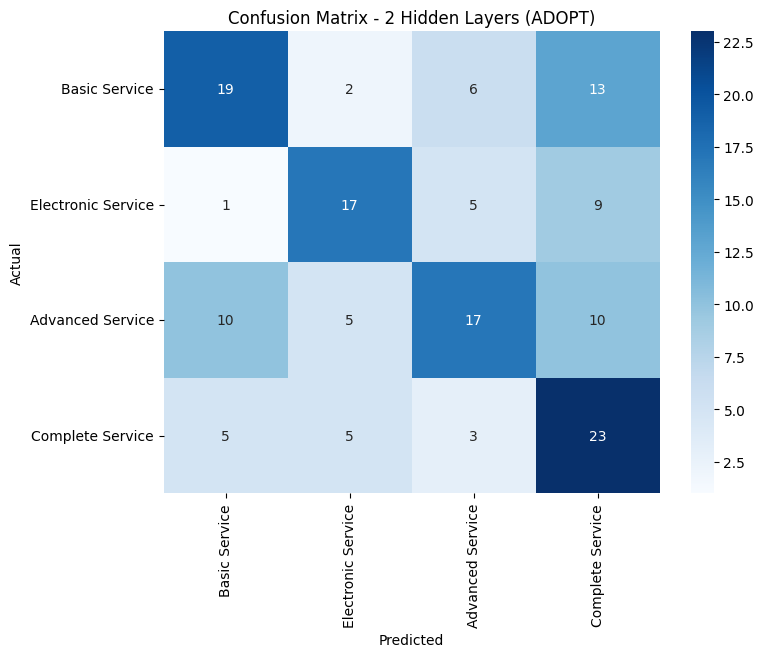

In [ ]:
# Train models for comparison using Adam, RMSprop, and ADOPT
model_adam_1_layer, _ = train_and_test(hidden_layers=1, neurons=best_neurons, batch_norm=True, dropout_rate=0.5,
                                       l2_reg=0.0001, optimizer_type='Adam', lr=0.001)
model_adam_2_layer, _ = train_and_test(hidden_layers=2, neurons=best_neurons_2_layer, batch_norm=True, dropout_rate=0.5,
                                       l2_reg=0.0001, optimizer_type='Adam', lr=0.001)

model_rmsprop_1_layer, _ = train_and_test(hidden_layers=1, neurons=best_neurons, batch_norm=True, dropout_rate=0.5,
                                          l2_reg=0.0001, optimizer_type='RMSprop', lr=0.001)
model_rmsprop_2_layer, _ = train_and_test(hidden_layers=2, neurons=best_neurons_2_layer, batch_norm=True, dropout_rate=0.5,
                                          l2_reg=0.0001, optimizer_type='RMSprop', lr=0.001)

model_adopt_1_layer, _ = train_and_test(hidden_layers=1, neurons=best_neurons, batch_norm=True, dropout_rate=0.5,
                                        l2_reg=0.0001, optimizer_type='ADOPT', lr=0.001)
model_adopt_2_layer, _ = train_and_test(hidden_layers=2, neurons=best_neurons_2_layer, batch_norm=True, dropout_rate=0.5,
                                        l2_reg=0.0001, optimizer_type='ADOPT', lr=0.001)

# Define a helper function for confusion matrix plotting
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Predictions for all configurations
y_pred_adam_1_layer = predict_classes(model_adam_1_layer, X_test_t)
y_pred_adam_2_layer = predict_classes(model_adam_2_layer, X_test_t)

y_pred_rmsprop_1_layer = predict_classes(model_rmsprop_1_layer, X_test_t)
y_pred_rmsprop_2_layer = predict_classes(model_rmsprop_2_layer, X_test_t)

y_pred_adopt_1_layer = predict_classes(model_adopt_1_layer, X_test_t)
y_pred_adopt_2_layer = predict_classes(model_adopt_2_layer, X_test_t)

# Confusion matrices for Adam optimizer
plot_confusion_matrix(y_test, y_pred_adam_1_layer, 'Confusion Matrix - 1 Hidden Layer (Adam)')
plot_confusion_matrix(y_test, y_pred_adam_2_layer, 'Confusion Matrix - 2 Hidden Layers (Adam)')

# Confusion matrices for RMSprop optimizer
plot_confusion_matrix(y_test, y_pred_rmsprop_1_layer, 'Confusion Matrix - 1 Hidden Layer (RMSprop)')
plot_confusion_matrix(y_test, y_pred_rmsprop_2_layer, 'Confusion Matrix - 2 Hidden Layers (RMSprop)')

# Confusion matrices for ADOPT optimizer
plot_confusion_matrix(y_test, y_pred_adopt_1_layer, 'Confusion Matrix - 1 Hidden Layer (ADOPT)')
plot_confusion_matrix(y_test, y_pred_adopt_2_layer, 'Confusion Matrix - 2 Hidden Layers (ADOPT)')

# Step 6: Ensemble of Best Models

We'll Weighted ensemble models.


Weighted Ensemble Accuracy: 0.4467

Classification Report for Weighted Ensemble:
                    precision    recall  f1-score   support

     Basic Service       0.49      0.53      0.51        40
Electronic Service       0.48      0.41      0.44        32
  Advanced Service       0.47      0.43      0.45        42
  Complete Service       0.36      0.42      0.38        36

          accuracy                           0.45       150
         macro avg       0.45      0.44      0.45       150
      weighted avg       0.45      0.45      0.45       150



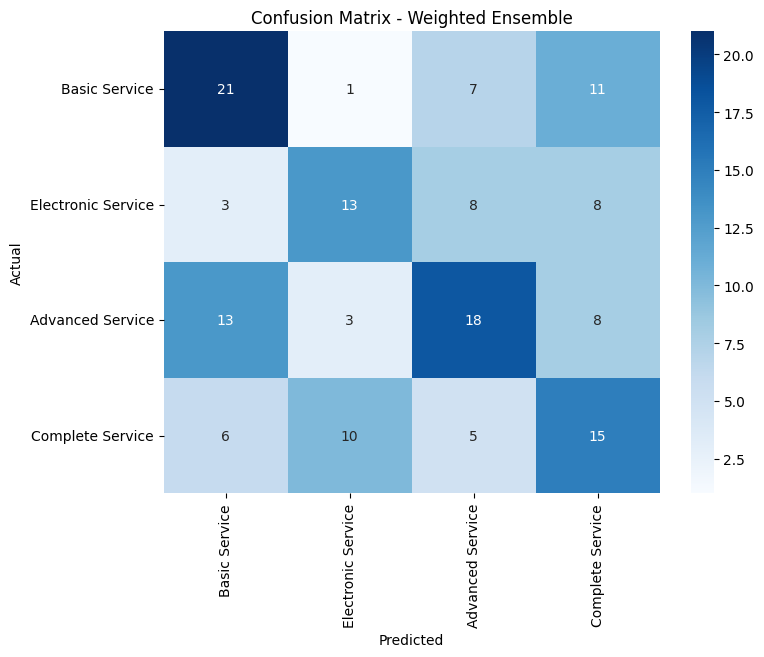

In [ ]:
"""# Step 6: Compute Probabilities for All Models"""

def predict_probabilities(model, X):
    model.eval()
    with torch.no_grad():
        out = nn.Softmax(dim=1)(model(X))
        return out.cpu().numpy()

# Compute probabilities for each model
prob_adam_1_layer = predict_probabilities(model_adam_1_layer, X_test_t)
prob_adam_2_layer = predict_probabilities(model_adam_2_layer, X_test_t)

prob_rmsprop_1_layer = predict_probabilities(model_rmsprop_1_layer, X_test_t)
prob_rmsprop_2_layer = predict_probabilities(model_rmsprop_2_layer, X_test_t)

prob_adopt_1_layer = predict_probabilities(model_adopt_1_layer, X_test_t)
prob_adopt_2_layer = predict_probabilities(model_adopt_2_layer, X_test_t)

"""# Step 6: Ensemble with User-Assigned Weights"""

# Define weights based on your evaluation of confusion matrices
weights = {
    'adam_1_layer': 0.3,    # Higher weight for good accuracy
    'adam_2_layer': 0.25,   # Slightly lower than 1-layer Adam
    'rmsprop_1_layer': 0.2, # Balanced performance
    'rmsprop_2_layer': 0.15,
    'adopt_1_layer': 0.05,  # Lowest weights for ADOPT
    'adopt_2_layer': 0.05
}

# Compute weighted probabilities for ensemble
ensemble_prob = (
    weights['adam_1_layer'] * prob_adam_1_layer +
    weights['adam_2_layer'] * prob_adam_2_layer +
    weights['rmsprop_1_layer'] * prob_rmsprop_1_layer +
    weights['rmsprop_2_layer'] * prob_rmsprop_2_layer +
    weights['adopt_1_layer'] * prob_adopt_1_layer +
    weights['adopt_2_layer'] * prob_adopt_2_layer
)

# Final predictions from weighted probabilities
ensemble_preds = np.argmax(ensemble_prob, axis=1)

# Evaluate ensemble performance
ensemble_acc = accuracy_score(y_test, ensemble_preds)
print(f"\nWeighted Ensemble Accuracy: {ensemble_acc:.4f}")

# Classification Report for Ensemble
print("\nClassification Report for Weighted Ensemble:")
print(classification_report(y_test, ensemble_preds, target_names=class_names.values()))

# Confusion Matrix for Weighted Ensemble
ensemble_cm = confusion_matrix(y_test, ensemble_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(ensemble_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.title('Confusion Matrix - Weighted Ensemble')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

If the ensemble improves the accuracy over individual models, the reason is that combining predictions from multiple models can reduce variance and correct for individual model errors, leading to a more robust final prediction.